# Improving Neural Networks



**CE477: Machine Learning**



__Instructor:__ Dr. Ali Sharifi-Zarchi



__Author:__ Ramtin Moslemi



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/Imroving_NNs.ipynb)

[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/Imroving_NNs.ipynb)







---



## Notebook Objectives



In this notebook we are going to start with a dataset, and step by step, try and improve our models. We will build on what we have learned from the previous lectures and notebooks and use these lessons to obtain better results!

## Imports and Setup

In this notebook we are going to work with the `EMNIST` dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader

import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
# @title plotting functions

def plot_results(train_losses, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(test_accuracies) + 1, 1)
    axes[0].plot(xs, train_losses)
    axes[0].set_title('Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, test_accuracies)
    axes[1].set_title('Test Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.show()

In [3]:
# @title helper functions


def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss = 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the running loss
        running_loss += loss.item()
    # Calculate and return the average loss
    return running_loss / len(dataloader)


def test_step(model, dataloader, device=device):
    correct = 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        test_acc = test_step(model, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Test Accuracy = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), test_accs.append(test_acc)
    # Plot the results
    plot_results(train_losses, test_accs)
    return train_losses, test_accs

# Loading the Data

To work with the data we must first download the dataset using `EMNIST`. We will normalize our data as well to get better results during training.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset.classes
print(f'Classes:\n{classes}')

100%|██████████| 561753746/561753746 [00:04<00:00, 131858361.41it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


As always, we must next define our dataloaders.

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# First Try: Simple Net

First we start working by a simple neural network.

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(),
                                     nn.Linear(28*28, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

We will use a simple stochastic gradient descent optimizer and train the model.

Train Loss = 1.156 | Test Accuracy = 66.30% : 100%|██████████| 30/30 [14:10<00:00, 28.33s/it]


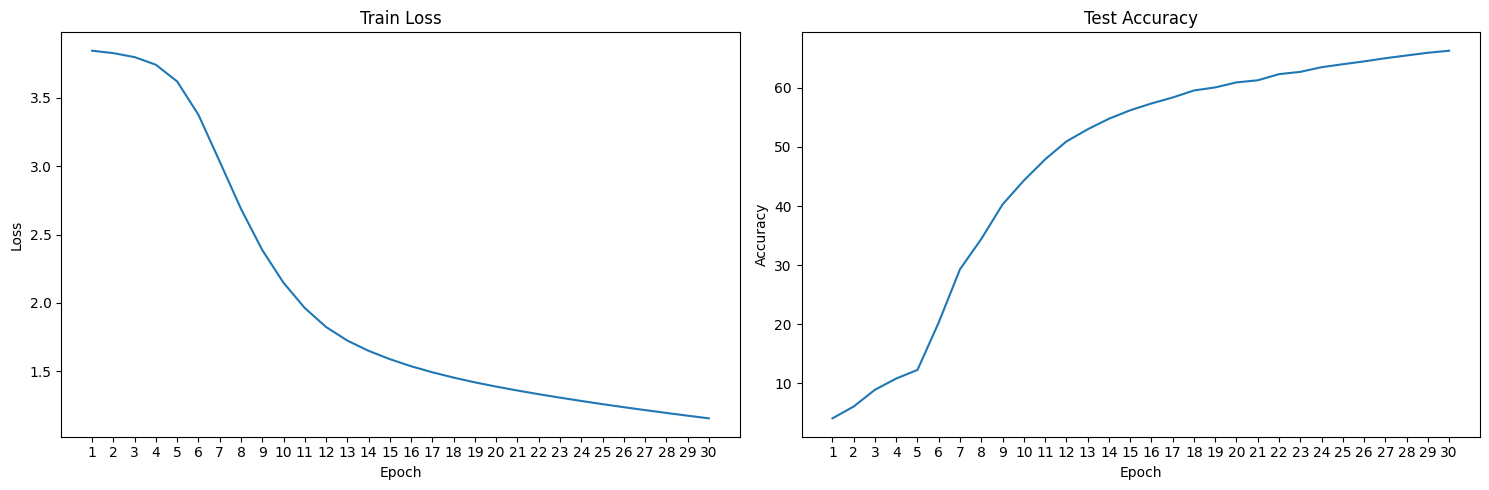

In [7]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

results = train_model(model, 30, optimizer, train_loader, test_loader)

It appears this dataset is far more challenging than the original `MNIST` digits dataset.


# Second Try: Adam Optimizer

As you recall, we can use better optimizers to speed up convergence.

Usually, the `Adam` optimizer is a good choice.

Train Loss = 0.359 | Test Accuracy = 82.66% : 100%|██████████| 20/20 [09:44<00:00, 29.23s/it]


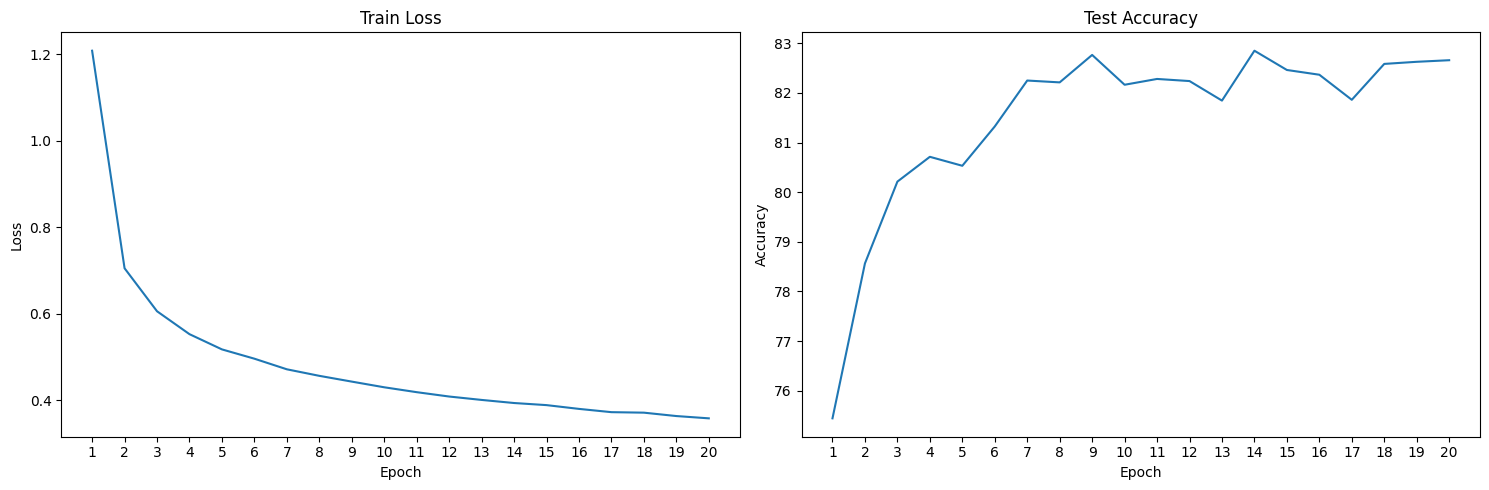

In [8]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Wow! Evidently replacing `SGD` with `Adam` improved our resutls drastically! 🔥

# Third Try: Deeper Network

Perhaps a bigger network could yield better results.

In [9]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(),
                                     nn.Linear(28*28, 512), nn.ReLU(),
                                     nn.Linear(512, 256), nn.ReLU(),
                                     nn.Linear(256, 256), nn.ReLU(),
                                     nn.Linear(256, 256), nn.ReLU(),
                                     nn.Linear(256, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 64), nn.ReLU(),
                                     nn.Linear(64, 64), nn.ReLU(),
                                     nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.347 | Test Accuracy = 83.69% : 100%|██████████| 20/20 [10:26<00:00, 31.33s/it]


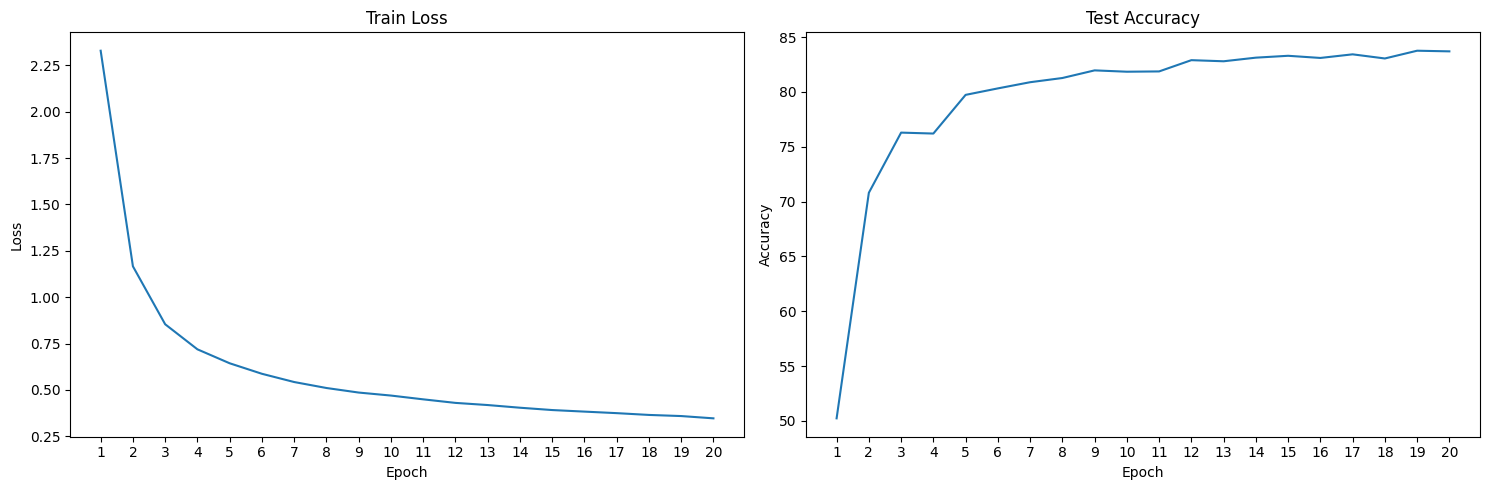

In [10]:
model = BiggerNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Hmm 🤔 it seems that making the network deeper wasn't that helpful. How can this be?

After all this bigger network has more representative power.
We will try to address this issue next.

# Fourth Try: Batch Normalization

In [11]:
class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(),
            nn.Linear(28*28, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.257 | Test Accuracy = 86.21% : 100%|██████████| 20/20 [11:28<00:00, 34.41s/it]


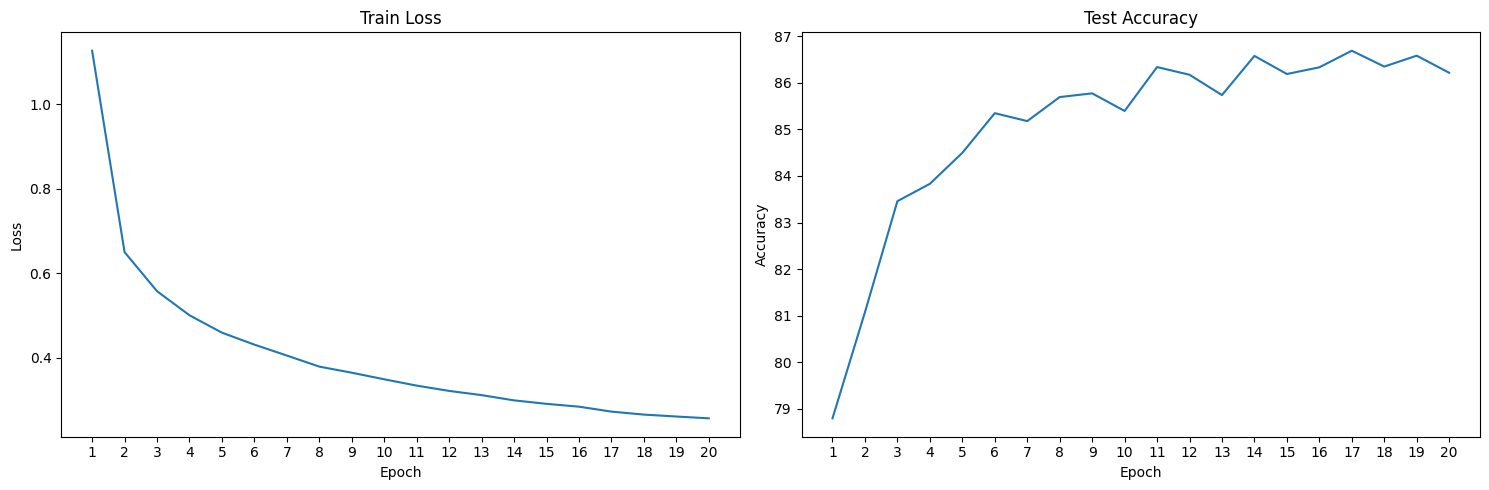

In [12]:
model = BiggerBN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

# Final Remarks

This notebook is to give you some sense as to how we go about improving neural networks.

The process involves a fair bit of experimentation.

However you should have the following takeaways from this notebook:





*   When in doubt, go with `Adam` as this also allows us to train for epochs or

*   use `Deeper Networks` that will outperform samller networks.

*   `Batch Normalization` does wonders!



A number of tips that were not covered in this notebook but you should keep in mind:





*   `Drop Out` layers can help with overfitting.

*   `Data Augmentation` can really help (don't worry we will learn more about this in the next chapter)

*   Incorporating the `Inductive Bias` allows us to come up with better architectures which in turn will yield much better results more efficiently! (our next two chapters will focus on the concept of different architectures)

*   Sometimes you must tune the hyperparameters to get the results you want.



Keep in mind some of these methods might not work as well as you expect and should always experiment on your own!

As a challenge try and apply the methods covered in this notebook in a different order to see their effects.






